ID #1: 311515381

ID #2: 206337768

# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: 311515381_206337768

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)
        
    def __str__(self):
        pass

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7f7b31cd5730>, <__main__.Node at 0x7f7b31cd5f70>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
def remove_columns_with_missing_values(data):
    data.dropna(axis=1, inplace=True)

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """

    p = np.unique(data[:,-1], return_counts=True)[1]/ data.shape[0]
    
    gini = 1 - np.dot(p,p)
    
    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    
    p = np.unique(data[:,-1], return_counts=True)[1]/ data.shape[0]
    entropy = np.dot(p, np.log2(p))*(-1)
    

    return entropy

In [10]:
A = np.array([['a'], ['b'], ['a'], ['a'], ['b'], ['b']])
B = np.array([['a'], ['a'], ['a'], ['a'], ['a'], ['a']])

assert (calc_gini(A) == 0.5) & (calc_entropy(A) == 1) & (calc_gini(B) == 0) & (calc_entropy(B) == 0), 'The functions are not correct -> please check again'

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [11]:
def goodness_of_split(data, attribute, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.

    Returns the goodness of split.  
    """
    
    s_prob = 0.0    
    # We calculate uncertainty before split
    node_impurity = impurity_func(data)
    feature_list = np.unique(data[:, attribute])
    for feature in feature_list:
        feature_data = data[data[:, attribute] == feature]
        impurity_feature = impurity_func(feature_data)
        prop = feature_data.shape[0]/data.shape[0]
        s_prob += prop * impurity_feature
        
    goodness = node_impurity - s_prob
    
    if gain_ratio:
        
        prob = np.unique(data[:, attribute], return_counts=True)[1] / data.shape[0]
        split_information = np.dot(prob, np.log2(prob))*(-1)
        
        if len(np.unique(data[:, attribute])) == 1:
               goodness = 0
        else:
            goodness = goodness_of_split(data,attribute,calc_entropy) / split_information
        
    return goodness

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [12]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self,data,attribute='leaf',depth=None,feature=None,parent='ROOT',parent_attribute='ROOT',pred=None):
        
        self.attribute = attribute # column index of criteria being tested
        self.data = data
        self.depth = depth
        self.label_dict = {} 
        self.feature = feature
        self.parent = parent
        self.parent_attribute = parent_attribute
        self.pred = pred
        self.children = []
        
    def add_child(self, node):
        self.children.append(node)

In [13]:
def build_tree(data,impurity,node_feature='ROOT',gain_ratio=False,depth=0,min_samples_split=1,max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """   
    root = None
    
    # Update the label dict {'p': 0 , 'e': 0}
    labels, counts = np.unique(data[:, -1], return_counts=True)
    root = DecisionNode(data=data,feature=node_feature,depth=depth,pred=labels[np.argmax(counts)])
    root.label_dict = dict(zip(labels,counts))
   
    # We check if the conditions apply
    if max_depth == 0 or len(labels) == 1 or data.shape[0] < min_samples_split:
        return root
    
    # We check for max gain attribute
    gain_list = []
    for att_indx in range(data.shape[1]-1):
        gain_list.append(goodness_of_split(data,att_indx,impurity,gain_ratio))
    best_att=max(enumerate(gain_list),key=lambda item:item[1])[0]
     
    # Update node max gain attribute index
    root.attribute = best_att
    
    # Create feature list
    features_list = np.unique(data[:,best_att])
    if len(features_list) == 1:
        return root
    
    for features in features_list:
        # Create child node data
        node_data = data[data[:,best_att] == features]
        # Create child node
        child_node = build_tree(data=node_data,impurity=impurity,node_feature=features,\
                                gain_ratio=gain_ratio,depth=depth+1,\
                                min_samples_split=min_samples_split,max_depth = max_depth-1)
        # Add childrens to current node
        root.add_child(child_node)
        # Update node parent
        child_node.parent = root.feature
        child_node.parent_attribute = root.attribute
    return root

In [14]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
print('Tree gini is ready!')
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
print('Tree entropy is ready!')
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio
print('Tree entropy gain ratio is ready!')

Tree gini is ready!
Tree entropy is ready!
Tree entropy gain ratio is ready!


# Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [15]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    
    while len(node.children) > 0:
        
        node_att = node.attribute
        instance_feature = instance[node_att]

        child = [child for child in node.children if child.feature == instance_feature]
        
        try:
            node = child[0]
        except IndexError:
            return node.pred 
        
    return node.pred

In [16]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    dataset_labels = dataset[:,-1]
    pred_array = np.array([predict(node, instance) for instance in dataset])
    accuracy = (dataset_labels == pred_array).sum() / dataset.shape[0] 
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [17]:
test_set_accuracies = {
    tree_gini: calc_accuracy(tree_gini, X_test),
    tree_entropy: calc_accuracy(tree_entropy, X_test),
    tree_entropy_gain_ratio: calc_accuracy(tree_entropy_gain_ratio, X_test)
}

print(f'X_train Gini: Achived {calc_accuracy(tree_gini, X_train):.3%} accuracy')
print(f'X_test Gini: Achived {test_set_accuracies[tree_gini]:.3%} accuracy')

print(f'X_train Entropy: Achived {calc_accuracy(tree_entropy, X_train):.3%} accuracy')
print(f'X_test Entropy: Achived {test_set_accuracies[tree_entropy]:.3%} accuracy')
print(f'X_train Entropy_gain_ratio: Achived {calc_accuracy(tree_entropy_gain_ratio, X_train):.3%} accuracy')
print(f'X_test Entropy_gain_ratio: Achived {test_set_accuracies[tree_entropy_gain_ratio]:.3%} accuracy')

X_train Gini: Achived 99.376% accuracy
X_test Gini: Achived 77.499% accuracy
X_train Entropy: Achived 99.475% accuracy
X_test Entropy: Achived 77.253% accuracy
X_train Entropy_gain_ratio: Achived 99.770% accuracy
X_test Entropy_gain_ratio: Achived 78.533% accuracy


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.


best result is achieved when the max_depth is 4 with 89.56% accuracy



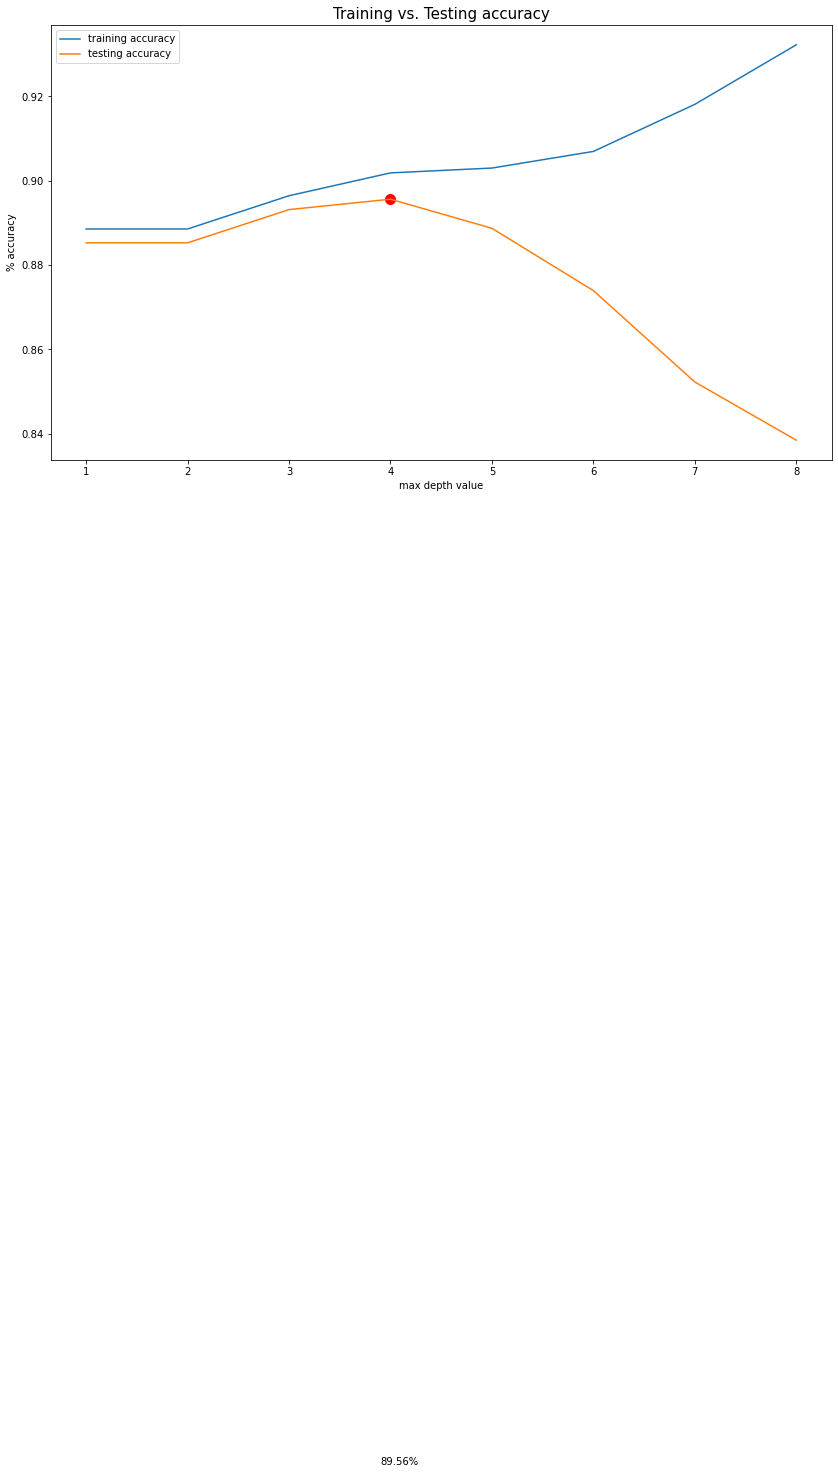

In [18]:
max_depth_values = np.arange(1,9)
training_accuracy = {}
testing_accurcay = {}

for max_depth_value in max_depth_values:
    max_depth_tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True,max_depth=max_depth_value)
    training_accuracy[max_depth_value] = calc_accuracy(max_depth_tree, X_train)
    testing_accurcay[max_depth_value] = calc_accuracy(max_depth_tree, X_test)

max_res_idx_max_depth = max(testing_accurcay, key=testing_accurcay.get)
print(f"\nbest result is achieved when the max_depth is {max_res_idx_max_depth} with {testing_accurcay[max_res_idx_max_depth]:.2%} accuracy\n")

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
axes.plot(training_accuracy.keys(), training_accuracy.values(), label='training accuracy')
axes.plot(testing_accurcay.keys(), testing_accurcay.values(), label='testing accuracy')
axes.set_title("Training vs. Testing accuracy", fontsize=15)
axes.set_xlabel("max depth value", fontsize=10)
axes.set_ylabel(f"{'%'} accuracy", fontsize=10)
axes.scatter(max_res_idx_max_depth, testing_accurcay[max_res_idx_max_depth], 100, 'r')
axes.text(max_res_idx_max_depth-0.1, testing_accurcay[max_res_idx_max_depth]-0.3, s=f'{testing_accurcay[max_res_idx_max_depth]:.2%}')
axes.legend()

## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)


best result is achieved when the max_depth is 50 with 89.51% accuracy



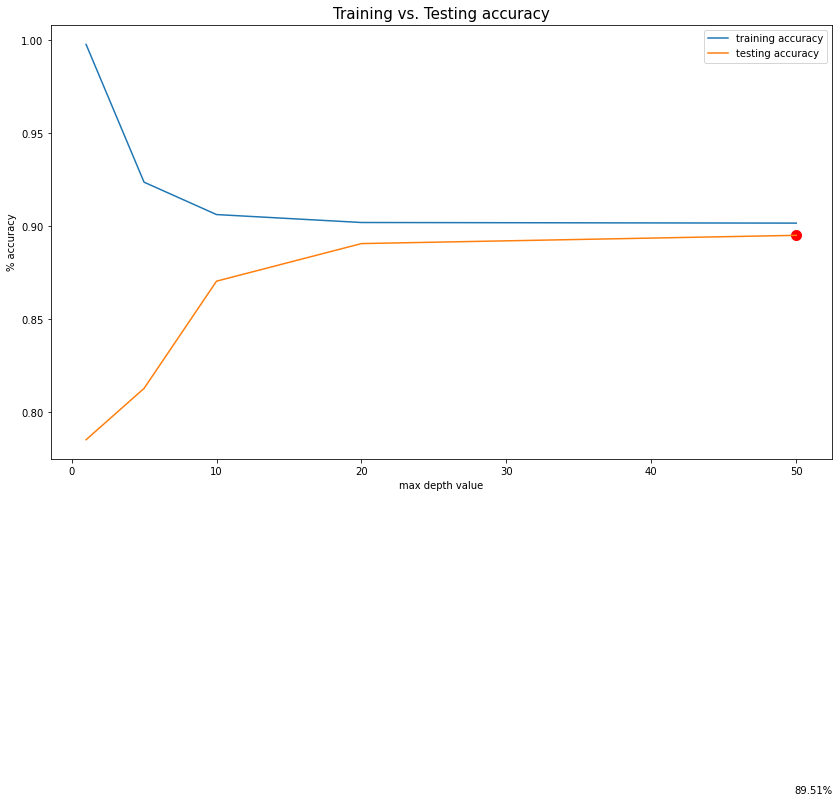

In [19]:
min_samples_list = [1,5,10,20,50]
training_accuracy = {}
testing_accurcay = {}

for min_sample_split in min_samples_list:
    min_samples_tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True,min_samples_split=min_sample_split)
    training_accuracy[min_sample_split] = calc_accuracy(min_samples_tree, X_train)
    testing_accurcay[min_sample_split] = calc_accuracy(min_samples_tree, X_test)

min_res_idx_min_depth = max(testing_accurcay, key=testing_accurcay.get)
print(f"\nbest result is achieved when the max_depth is {min_res_idx_min_depth} with {testing_accurcay[min_res_idx_min_depth]:.2%} accuracy\n")

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
axes.plot(training_accuracy.keys(), training_accuracy.values(), label='training accuracy')
axes.plot(testing_accurcay.keys(), testing_accurcay.values(), label='testing accuracy')
axes.set_title("Training vs. Testing accuracy", fontsize=15)
axes.set_xlabel("max depth value", fontsize=10)
axes.set_ylabel(f"{'%'} accuracy", fontsize=10)
axes.scatter(min_res_idx_min_depth, testing_accurcay[min_res_idx_min_depth], 100, 'r')
axes.text(min_res_idx_min_depth-0.1, testing_accurcay[min_res_idx_min_depth]-0.3, s=f'{testing_accurcay[min_res_idx_min_depth]:.2%}')
axes.legend()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [20]:
tree_max_depth = build_tree(X_train,calc_entropy,node_feature='ROOT',gain_ratio=True,depth=0,min_samples_split=1,max_depth=4)
tree_min_samples_split = build_tree(X_train,calc_entropy,node_feature='ROOT',gain_ratio=True,depth=0,min_samples_split=50,max_depth=1000)

## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [21]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    num_nodes = 1
    for child in node.children:
        num_nodes += count_nodes(child)
        
    return num_nodes

In [22]:
print(f'Tree gini:\nNnumber of nodes is {count_nodes(node=tree_gini)}')
print(f'Tree entropy:\nNumber of nodes is {count_nodes(node=tree_entropy)}')
print(f'Tree entropy gain ratio:\nNumber of nodes is {count_nodes(node=tree_entropy_gain_ratio)}')
print(f'Tree max depth:\nNumber of nodes is {count_nodes(node=tree_max_depth)}')
print(f'Tree min samples split:\nNumber of nodes is {count_nodes(node=tree_min_samples_split)}')

Tree gini:
Nnumber of nodes is 3263
Tree entropy:
Number of nodes is 3247
Tree entropy gain ratio:
Number of nodes is 3275
Tree max depth:
Number of nodes is 205
Tree min samples split:
Number of nodes is 349


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [23]:
def print_tree(tree_func = None,max_depth=50):
# you can change the function signeture
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    node = None
    node = tree_func
    
    if len(node.children)==0:
        print(f"{'    ' *node.depth}[X{node.parent_attribute}={node.feature}, leaf]: [{node.label_dict}]")
    else:
        attribute_name = 'ROOT' if node.feature == 'ROOT' else f'X{node.parent_attribute}={node.feature}'
        print(f"{'    ' *node.depth}[{attribute_name}, attribute=X{node.attribute}]")
    
    if node.depth < max_depth:
        if len(node.children) > 0:
            for child in range(len(node.children)):
                child_node = node.children[child]
                print_tree(tree_func=child_node,max_depth=max_depth)
    return 

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [24]:
# Print best tree accuarcy
def print_best_tree(data):
    tree_accuracy_list = []
    for max_depth_value in max_depth_values:
        for min_sample_split in min_samples_list:
            tree = build_tree(data=data, impurity=calc_entropy, gain_ratio=True,\
                              min_samples_split=min_sample_split,max_depth=max_depth_value)
            total_nodes = count_nodes(tree)
            if total_nodes > 50:
                tree_accuracy_list.append((0,max_depth_value,min_sample_split))
            else:
                tree_accuracy_list.append((calc_accuracy(tree,X_test),max_depth_value,min_sample_split))
    best_depth = max(tree_accuracy_list,key=lambda item:item[0])[1]
    best_sample = max(tree_accuracy_list,key=lambda item:item[0])[2]
    
    print_tree(tree_func=build_tree(X_train,impurity=calc_entropy,node_feature='ROOT',gain_ratio=True,\
                                    depth=0,min_samples_split=best_sample,max_depth=best_depth))

In [25]:
print_best_tree(X_train)

[ROOT, attribute=X4]
    [X4=a, leaf]: [{'e': 273, 'p': 31}]
    [X4=c, leaf]: [{'e': 10, 'p': 137}]
    [X4=f, leaf]: [{'e': 170, 'p': 1438}]
    [X4=l, leaf]: [{'e': 272, 'p': 27}]
    [X4=m, leaf]: [{'e': 2, 'p': 25}]
    [X4=n, leaf]: [{'e': 2332, 'p': 344}]
    [X4=p, leaf]: [{'e': 8, 'p': 175}]
    [X4=s, leaf]: [{'e': 38, 'p': 380}]
    [X4=y, leaf]: [{'e': 49, 'p': 382}]


In [26]:
# for verification only
print_tree(tree_gini)

[ROOT, attribute=X4]
    [X4=a, attribute=X2]
        [X2=n, attribute=X8]
            [X8=n, attribute=X19]
                [X19=s, attribute=X0]
                    [X0=f, attribute=X18]
                        [X18=k, leaf]: [{'e': 1}]
                        [X18=n, attribute=X20]
                            [X20=g, leaf]: [{'e': 1}]
                            [X20=p, leaf]: [{'p': 1}]
                    [X0=x, leaf]: [{'e': 2, 'p': 2}]
                [X19=y, leaf]: [{'e': 8}]
            [X8=p, attribute=X0]
                [X0=f, attribute=X19]
                    [X19=s, leaf]: [{'e': 2}]
                    [X19=y, leaf]: [{'p': 1}]
                [X0=x, leaf]: [{'e': 7}]
            [X8=w, attribute=X18]
                [X18=k, attribute=X0]
                    [X0=f, leaf]: [{'e': 3}]
                    [X0=x, attribute=X20]
                        [X20=g, leaf]: [{'p': 1}]
                        [X20=p, leaf]: [{'e': 2}]
                [X18=n, leaf]: [{'e': 7}]
      

            [X11=k, attribute=X20]
                [X20=d, attribute=X0]
                    [X0=f, leaf]: [{'p': 12}]
                    [X0=k, attribute=X12]
                        [X12=p, leaf]: [{'p': 6}]
                        [X12=w, attribute=X1]
                            [X1=s, attribute=X2]
                                [X2=e, leaf]: [{'e': 1}]
                                [X2=n, leaf]: [{'p': 2}]
                            [X1=y, attribute=X2]
                                [X2=e, leaf]: [{'p': 1}]
                                [X2=n, leaf]: [{'e': 1}]
                    [X0=x, attribute=X1]
                        [X1=s, attribute=X10]
                            [X10=k, attribute=X12]
                                [X12=p, leaf]: [{'e': 1}]
                                [X12=w, leaf]: [{'p': 2}]
                            [X10=s, leaf]: [{'p': 3}]
                        [X1=y, leaf]: [{'p': 5}]
                [X20=l, attribute=X12]
                    [